### Handling bd CPS observations whose hours vary

Brian Dew<br>
May 6, 2021

----

Starting in 1994, CPS respondents could report that their usual hours vary. Because the bd CPS derives hourly wages for nonhourly workers from usual weekly earnings divided by usual weekly hours, the extracts' hourly wage series has holes where nonhourly workers usual hours vary.


Replacing the missing usual hours variable with actual hours would inflate hourly wages for individuals with paid absenses from work or who are paid for full-time work but worked part-time. Likewise, observations that worked more hours than usual would have artificially low hourly wage estimates. 


When at CEPR, John Schmitt handled the hours vary problem by imputing usual hours for workers who are not paid hourly but whose hours vary. The CEPR imputation comes from the results of four regressions that seek to explain usual hours of workers who report usual hours based on age, education, race, marital status, nativity, and citizenship. The four regressions correspond to four groups (men or women and usually full-time or usually part-time).

Here's an example:

```
		/* FT, women */
reg pehrusl1 age `agesq' `white' `black' `hisp' /*
*/ `lths' `hs' `col' `adv' married forborn citizen /*
*/ if empl==1 & selfemp==0 & hrsvary==0 & /*
*/ (3<=prhrusl & prhrusl<=6) & female==1
predict imphr1 if female==1 & prhrusl==7 /* varies, FT */

```

Then, the CEPR program creates a new variable, `uhoursi` that is equal to usual hours when hours don't vary, "hours paid at this rate" when hours vary and paid hourly, and the regression prediction when hours vary and not paid hourly.  


Before deciding how to approach the "hours vary" problem, I want to look at some summary statistics and lay out some options. 


#### Options include:

- CEPR approach verbatim
- CEPR approach different regressions
- Use actual hours
- Calculate usual hours for 7-8x matched observations
- Calculate usual hours for 3x+ matched observations
- Fill in only those whose actual hours aren't typical


Beyond basic summary statistics, perhaps there is some additional information in longitudinally matched data. For some (probably small) portion of fully-matched people, I'll be able to find 8 observations that all report "hours vary" and all have the same industry and occupation code, about the same weekly pay, and all report actual hours. For that group I can see how much actual hours vary when measured 8 times. 


Separately, one simple option is to use the CEPR regressions but also add 11 month binary variables to address seasonality in hours vary data. 

In [1]:
%config Completer.use_jedi = False
import pandas as pd
import numpy as np 
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os, itertools

os.chdir('/home/brian/Documents/CPS/data/clean/')

In [2]:
cols = ['YEAR', 'MONTH', 'HRSUSL1', 'PWSSWGT', 'FEMALE', 'FTLF', 
        'INDGRP', 'AGE', 'MARRIED', 'EDUC', 'WBHAO', 'FORBORN',
        'EDUCDT', 'CITIZEN', 'COW1', 'REGION', 'STATE',
        'NUMJOBS', 'PAIDHRLY', 'INDM', 'MANAGER', 'HRSUSL1I']

agesq = lambda x: x['AGE'].astype('int')**2
agecu = lambda x: x['AGE'].astype('int')**3
private = lambda x: np.where(x['COW1'] == 'Private', 1, 0)
se = ['Self-employed Incorporated', 'Self-employed Unincorporated']
selfemp = lambda x: np.where(x.COW1.isin(se), 1, 0)


df = pd.concat([(pd.read_feather(f'cps{year}.ft', columns=cols)
                   .assign(AGESQ = agesq,
                           AGECU = agecu,
                           PRIVATE = private,
                           SELFEMP = selfemp))
                for year in range(1994, 2024)])

cond = [(df.HRSUSL1 == -4), (df.HRSUSL1 > 0)]
labels = ['Hours Vary', 'Hours reported']

df['HRSVRY'] = np.select(cond, labels, default=None).astype(pd.Categorical)

dfc = df.loc[df['HRSVRY'] == 'Hours Vary']

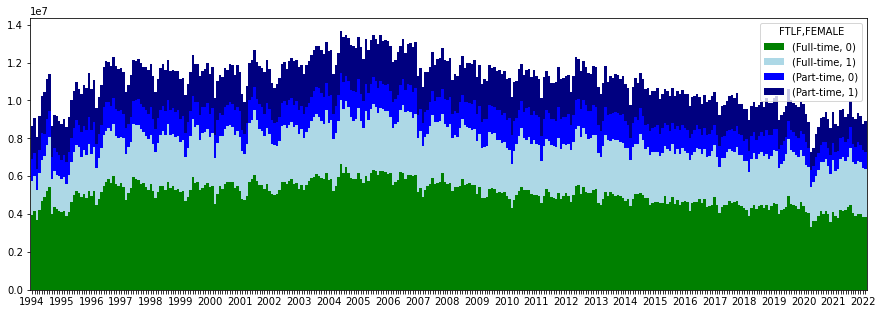

In [3]:
def tick_label(index):
    label = ''
    if index.month[:3] == 'Jan':
        label += f'{index.year}'
    return label

groups = ['YEAR', 'MONTH', 'FEMALE', 'FTLF']
res = dfc.groupby(groups).PWSSWGT.sum().unstack().unstack()
res = res[res[('Full-time', 1)] > 0]
idx = [pd.to_datetime(f'{year}-{month}-01') 
       for year, month in res.index]

res.index = idx

ax = res.plot(kind='bar', stacked=True, figsize=(15, 5), width=1, 
              rot=0, color=['green', 'lightblue', 'blue', 'navy'])
ax.set_xticklabels([i.year if i.month == 1 else '' for i in idx]);

In [4]:
#grp = df.query('FTLF == "Full-time" and FEMALE == 0')
#tot = grp.query('HRSVRY.notnull()').PWSSWGT.sum()
#hv = grp.query('HRSVRY == "Hours Vary"').groupby(['INDM']).PWSSWGT.sum()
#(tot / hv).round()

In [5]:
dft = df.query('YEAR == 2019 and MONTH == 10')
grp = dft.query('FTLF == "Full-time" and FEMALE == 0')

In [6]:
# Refression formula
spec = '''HRSUSL1 ~ AGE + AGESQ + AGECU + C(WBHAO) + C(EDUCDT) + 
          MARRIED + CITIZEN + FORBORN + PRIVATE + 
          C(STATE) + NUMJOBS + C(INDM) + MANAGER + SELFEMP'''
data = grp.query('HRSUSL1 > 0')
mod = smf.ols(formula=spec, data=data)
res = mod.fit()

In [7]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                HRSUSL1   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     31.97
Date:                Tue, 29 Mar 2022   Prob (F-statistic):               0.00
Time:                        20:58:55   Log-Likelihood:                -85910.
No. Observations:               24638   AIC:                         1.720e+05
Df Residuals:                   24543   BIC:                         1.728e+05
Df Model:                          94                                         
Covariance Type:            nonrobust                                         
===========================================================================================================================================================================
                                                                                                              coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                  44.4310      1.584     28.043      0.000      41.326      47.536
C(WBHAO)[T.Black]                                                                                           0.0532      0.295      0.180      0.857      -0.525       0.632
C(WBHAO)[T.Hispanic]                                                                                        0.4352      0.261      1.670      0.095      -0.076       0.946
C(WBHAO)[T.Other]                                                                                           0.8428      0.537      1.570      0.116      -0.209       1.895
C(WBHAO)[T.White]                                                                                           1.3132      0.247      5.317      0.000       0.829       1.797
C(EDUCDT)[T.11th grade]                                                                                    -0.0899      0.660     -0.136      0.892      -1.384       1.204
C(EDUCDT)[T.12th grade-no diploma]                                                                          0.4748      0.727      0.653      0.514      -0.951       1.900
C(EDUCDT)[T.1st-4th grade]                                                                                 -0.8183      0.953     -0.859      0.390      -2.686       1.049
C(EDUCDT)[T.5th-6th grade]                                                                                 -1.1482      0.718     -1.598      0.110      -2.556       0.260
C(EDUCDT)[T.7th-8th grade]                                                                                 -0.8610      0.716     -1.202      0.229      -2.265       0.543
C(EDUCDT)[T.9th grade]                                                                                      0.4669      0.726      0.643      0.520      -0.956       1.890
C(EDUCDT)[T.Associate degree-academic program]                                                             -0.2278      0.552     -0.413      0.680      -1.309       0.853
C(EDUCDT)[T.Associate degree-occupational/vocational]                                                       0.6074      0.556      1.093      0.274      -0.482       1.696
C(EDUCDT)[T.Bachelor's degree]                                                                              0.2131      0.520      0.410      0.682      -0.805       1.231
C(EDUCDT)[T.Doctorate]                                                                                      2.1989      0.605      3.634      0.000       1.013

<AxesSubplot:xlabel='YEAR,MONTH'>

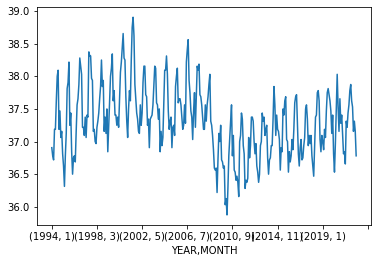

In [8]:
df.query('HRSUSL1 == -4').groupby(['YEAR', 'MONTH']).HRSUSL1I.mean().plot()